# Text Classification - Lab

## Introduction

In this lab, we'll use everything we've learned so far to build a model that can classify a text document as one of many possible classes!

## Objectives

You will be able to:

- Perform classification using a text dataset, using sensible preprocessing, tokenization, and feature engineering scheme 
- Use scikit-learn text vectorizers to fit and transform text data into a format to be used in a ML model 



# Getting Started

For this lab, we'll be working with the classic **_Newsgroups Dataset_**, which is available as a training data set in `sklearn.datasets`. This dataset contains many different articles that fall into 1 of 20 possible classes. Our goal will be to build a classifier that can accurately predict the class of an article based on the features we create from the article itself!

Let's get started. Run the cell below to import everything we'll need for this lab. 

In [1]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
np.random.seed(0)

Now, we need to fetch our dataset. Run the cell below to download all the newsgroups articles and their corresponding labels. If this is the first time working with this dataset, scikit-learn will need to download all of the articles from an external repository -- the cell below may take a little while to run. 

The actual dataset is quite large. To save us from extremely long runtimes, we'll work with only a subset of the classes. Here is a list of all the possible classes:

<img src='classes.png'>

For this lab, we'll only work with the following five:

* `'alt.atheism'`
* `'comp.windows.x'`
* `'rec.sport.hockey'`
* `'sci.crypt'`
* `'talk.politics.guns'`

In the cell below:

* Create a list called `categories` that contains the five newsgroups classes listed above, as strings 
* Get the training set by calling `fetch_20newsgroups()` and passing in the following parameters:
    * `subset='train'`
    * `categories=categories`
    * `remove=('headers', 'footers', 'quotes')` -- this is so that the model can't overfit to metadata included in the articles that sometimes acts as a dead-giveaway as to what class the article belongs to  
* Get the testing set as well by passing in the same parameters, with the exception of `subset='test` 

In [2]:
categories = ['alt.atheism', 'comp.windows.x',
              'rec.sport.hockey','sci.crypt','talk.politics.guns']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories,
                                      remove=['headers','footers','quotes'])
newsgroups_test = fetch_20newsgroups(subset='test',categories=categories,
                                        remove=['headers','footers','quotes'])

Great! Let's break apart the data and the labels, and then inspect the class names to see what the actual newsgroups are.

In the cell below:

* Grab the data from `newsgroups_train.data` and store it in the appropriate variable  
* Grab the labels from `newsgroups_train.target` and store it in the appropriate variable  
* Grab the label names from `newsgroups_train.target_names` and store it in the appropriate variable  
* Display the `label_names` so that we can see the different classes of articles that we're working with, and confirm that we grabbed the right ones  

In [3]:
data = newsgroups_train.data
target = newsgroups_train.target
label_names = newsgroups_train.target_names
label_names

['alt.atheism',
 'comp.windows.x',
 'rec.sport.hockey',
 'sci.crypt',
 'talk.politics.guns']

Finally, let's check the shape of `data` to see what our data looks like. We can do this by checking the `.shape` attribute of `newsgroups_train.filenames`.

Do this now in the cell below.

In [4]:
# Your code here
newsgroups_train.filenames.shape

(2814,)

Our dataset contains 2,814 different articles spread across the five classes we chose. 

### Cleaning and Preprocessing Our Data

Now that we have our data, the fun part begins. We'll need to begin by preprocessing and cleaning our text data. As you've seen throughout this section, preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing and cleaning we need to do. Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?


These are all questions that we'll need to think about pretty much anytime we begin working with text data. 

Let's get right into it. We'll start by getting a list of all of the english stopwords, and concatenating them with a list of all the punctuation. 

In the cell below:

* Get all the english stopwords from `nltk` 
* Get all of the punctuation from `string.punctuation`, and convert it to a list 
* Add the two lists together. Name the result `stopwords_list` 
* Create another list containing various types of empty strings and ellipses, such as `["''", '""', '...', '``']`. Add this to our `stopwords_list`, so that we won't have tokens that are only empty quotes and such  

In [5]:
nltk.corpus.stopwords

<WordListCorpusReader in '/Users/jamesirving/nltk_data/corpora/stopwords'>

In [6]:
import nltk
import string
stopwords_list = nltk.corpus.stopwords.words('english')
stopwords_list.extend(string.punctuation)
stopwords_list.extend(["''", '""', '...', '`'])

In [7]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Great! We'll leave these alone for now, until we're ready to remove stop words after the tokenization step. 

Next, let's try tokenizing our dataset. In order to save ourselves some time, we'll write a function to clean our dataset, and then use Python's built-in `map()` function to clean every article in the dataset at the same time. 

In the cell below, complete the `process_article()` function. This function should:

* Take in one parameter, `article` 
* Tokenize the article using the appropriate function from `nltk` 
* Lowercase every token, remove any stopwords found in `stopwords_list` from the tokenized article, and return the results 

In [8]:
def process_article(article):
    tokens = nltk.tokenize.word_tokenize(article)  
    words = [w.lower() for w in tokens if w.lower() not in stopwords_list]
    return words

Now that we have this function, let's go ahead and preprocess our data, and then move into exploring our dataset. 

In the cell below:

* Use Python's `map()` function and pass in two parameters: the `process_article` function and the `data`. Make sure to wrap the whole map statement in a `list()`.

**_Note:_** Running this cell may take a minute or two!

In [9]:
processed_data = list(map(process_article,data))
processed_data[:5]

[['note',
  'trial',
  'updates',
  'summarized',
  'reports',
  '_idaho',
  'statesman_',
  'local',
  'nbc',
  'affiliate',
  'television',
  'station',
  'ktvb',
  'channel',
  '7',
  'randy',
  'weaver/kevin',
  'harris',
  'trial',
  'update',
  'day',
  '4',
  'friday',
  'april',
  '16',
  '1993',
  'fourth',
  'day',
  'trial',
  'synopsis',
  'defense',
  'attorney',
  'gerry',
  'spence',
  'cross-examined',
  'agent',
  'cooper',
  'repeated',
  'objections',
  'prosecutor',
  'ronald',
  'howen',
  'spence',
  'moved',
  'mistrial',
  'denied',
  'day',
  'marked',
  'caustic',
  'cross-examination',
  'deputy',
  'marshal',
  'larry',
  'cooper',
  'defense',
  'attorney',
  'gerry',
  'spence',
  'although',
  'spence',
  'explicitly',
  'stated',
  'one',
  'angle',
  'stategy',
  'must',
  'involve',
  'destroying',
  'credibility',
  'agent',
  'cooper',
  'cooper',
  'government',
  "'s",
  'eyewitness',
  'death',
  'agent',
  'degan',
  'spence',
  'attacked',
  'co

In [10]:
# processed_data = None

Great. Now, let's inspect the first article in `processed_data` to see how it looks. 

Do this now in the cell below.

In [11]:
# processed_data[0]

Now, let's move onto exploring the dataset a bit more. Let's start by getting the total vocabulary size of the training dataset. We can do this by creating a `set` object and then using it's `.update()` method to iteratively add each article. Since it's a set, it will only contain unique words, with no duplicates. 

In the cell below:

* Create a `set()` object called `total_vocab` 
* Iterate through each tokenized article in `processed_data` and add it to the set using the set's `.update()` method 
* Once all articles have been added, get the total number of unique words in our training set by taking the length of the set 

In [12]:
total_vocab = set()
[total_vocab.update(text) for text in processed_data]
len(total_vocab)


46991

### Exploring Data With Frequency Distributions

Great -- our processed dataset contains 46,990 unique words! 

Next, let's create a frequency distribution to see which words are used the most! 

In order to do this, we'll need to concatenate every article into a single list, and then pass this list to `FreqDist()`. 

In the cell below:

* Create an empty list called `articles_concat` 
* Iterate through `processed_data` and add every article it contains to `articles_concat` 
* Pass `articles_concat` as input to `FreqDist()`  
* Display the top 200 most used words  

In [13]:
# processed_data

In [14]:
articles_concat = []
[articles_concat.extend(text) for text in processed_data]
len(articles_concat)

416037

In [15]:
articles_concat[0:100]

['note',
 'trial',
 'updates',
 'summarized',
 'reports',
 '_idaho',
 'statesman_',
 'local',
 'nbc',
 'affiliate',
 'television',
 'station',
 'ktvb',
 'channel',
 '7',
 'randy',
 'weaver/kevin',
 'harris',
 'trial',
 'update',
 'day',
 '4',
 'friday',
 'april',
 '16',
 '1993',
 'fourth',
 'day',
 'trial',
 'synopsis',
 'defense',
 'attorney',
 'gerry',
 'spence',
 'cross-examined',
 'agent',
 'cooper',
 'repeated',
 'objections',
 'prosecutor',
 'ronald',
 'howen',
 'spence',
 'moved',
 'mistrial',
 'denied',
 'day',
 'marked',
 'caustic',
 'cross-examination',
 'deputy',
 'marshal',
 'larry',
 'cooper',
 'defense',
 'attorney',
 'gerry',
 'spence',
 'although',
 'spence',
 'explicitly',
 'stated',
 'one',
 'angle',
 'stategy',
 'must',
 'involve',
 'destroying',
 'credibility',
 'agent',
 'cooper',
 'cooper',
 'government',
 "'s",
 'eyewitness',
 'death',
 'agent',
 'degan',
 'spence',
 'attacked',
 'cooper',
 "'s",
 'credibility',
 'pointing',
 'discrepancies',
 'cooper',
 "'s",
 '

In [16]:
articles_freqdist = FreqDist(articles_concat)
articles_freqdist.most_common(200)

[('--', 29501),
 ('x', 4840),
 ('``', 4071),
 ("'s", 3203),
 ("n't", 2933),
 ('1', 2529),
 ('would', 1985),
 ('0', 1975),
 ('one', 1758),
 ('2', 1664),
 ('people', 1243),
 ('use', 1146),
 ('get', 1068),
 ('like', 1036),
 ('file', 1024),
 ('3', 1005),
 ('also', 875),
 ('key', 869),
 ('4', 864),
 ('could', 853),
 ('know', 814),
 ('think', 814),
 ('time', 781),
 ('may', 729),
 ('even', 711),
 ('new', 706),
 ('first', 678),
 ('*/', 674),
 ('system', 673),
 ('5', 673),
 ('well', 670),
 ('information', 646),
 ('make', 644),
 ('right', 638),
 ('see', 636),
 ('many', 634),
 ('two', 633),
 ('/*', 611),
 ('good', 608),
 ('used', 600),
 ('7', 593),
 ('government', 588),
 ('way', 572),
 ('available', 568),
 ('window', 568),
 ("'m", 562),
 ('db', 553),
 ('much', 540),
 ('encryption', 537),
 ('6', 537),
 ('using', 527),
 ('say', 523),
 ('gun', 520),
 ('number', 518),
 ('program', 515),
 ('us', 510),
 ('team', 498),
 ('must', 483),
 ('law', 476),
 ('since', 449),
 ('need', 444),
 ('game', 439),
 ('ch

At first glance, none of these words seem very informative -- for most of the words represented here, it would be tough to guess if a given word is used equally among all five classes, or is disproportionately represented among a single class. This makes sense, because this frequency distribution represents all the classes combined. This tells us that these words are probably the least important, as they are most likely words that are used across multiple classes, thereby providing our model with little actual signal as to what class they belong to. This tells us that we probably want to focus on words that appear heavily in articles from a given class, but rarely appear in articles from other classes. You may recall from previous lessons that this is exactly where **_TF-IDF Vectorization_** really shines!

### Vectorizing with TF-IDF

Although NLTK does provide functionality for vectorizing text documents with TF-IDF, we'll make use of scikit-learn's TF-IDF vectorizer, because we already have experience with it, and because it's a bit easier to use, especially when the models we'll be feeding the vectorized data into are from scikit-learn, meaning that we don't have to worry about doing any extra processing to ensure they play nicely together. 

Recall that in order to use scikit-learn's `TfidfVectorizer()`, we need to pass in the data as raw text documents -- the `TfidfVectorizer()` handles the count vectorization process on it's own, and then fits and transforms the data into TF-IDF format. 

This means that we need to:

* Import `TfidfVectorizer` from `sklearn.feature_extraction.text` and instantiate `TfidfVectorizer()` 
* Call the vectorizer object's `.fit_transform()` method and pass in our `data` as input. Store the results in `tf_idf_data_train` 
* Also create a vectorized version of our testing data, which can be found in `newsgroups_test.data`. Store the results in `tf_idf_data_test`. 


**_NOTE:_** When transforming the test data, use the `.transform()` method, not the `.fit_transform()` method, as the vectorizer has already been fit to the training data. 

In [17]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
vectorizer = TfidfVectorizer()

In [19]:
tf_idf_data_train = vectorizer.fit_transform(data)

In [20]:
tf_idf_data_test = vectorizer.transform(newsgroups_test.data)

### Modeling Our Data

Great! We've now preprocessed and explored our dataset, let's take a second to see what our data looks like in vectorized form. 

In the cell below, get the shape of `tf_idf_data`.

In [21]:
len(data)

2814

In [22]:
tf_idf_data_train.shape

(2814, 36622)

In [23]:
# Your code here

Our vectorized data contains 2,814 articles, with 36,622 unique words in the vocabulary. However, the vast majority of these columns for any given article will be zero, since every article only contains a small subset of the total vocabulary. Recall that vectors mostly filled with zeros are referred to as **_Sparse Vectors_**. These are extremely common when working with text data. 

Let's check out the average number of non-zero columns in the vectors. Run the cell below to calculate this average. 

In [24]:
# help(tf_idf_data_train)

In [25]:
non_zero_cols = tf_idf_data_train.nnz / float(tf_idf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tf_idf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 107.28038379530916
Percentage of columns containing 0: 0.9970706028126451


As we can see from the output above, the average vectorized article contains 107 non-zero columns. This means that 99.7% of each vector is actually zeroes! This is one reason why it's best not to create your own vectorizers, and rely on professional packages such as scikit-learn and NLTK instead -- they contain many speed and memory optimizations specifically for dealing with sparse vectors. This way, we aren't wasting a giant chunk of memory on a vectorized dataset that only has valid information in 0.3% of it. 

Now that we've vectorized our dataset, let's create some models and fit them to our vectorized training data. 

In the cell below:

* Instantiate `MultinomialNB()` and `RandomForestClassifier()`. For random forest, set `n_estimators` to `100`. Don't worry about tweaking any of the other parameters  
* Fit each to our vectorized training data 
* Create predictions for our training and test sets
* Calculate the `accuracy_score()` for both the training and test sets (you'll find our training labels stored within the variable `target`, and the test labels stored within `newsgroups_test.target`) 

In [26]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier()

In [27]:
nb_classifier.fit(tf_idf_data_train,target)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [28]:
rf_classifier.fit(tf_idf_data_train,target)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [29]:
nb_train_score = accuracy_score(target,nb_train_preds)
nb_test_score = accuracy_score(newsgroups_test.target,nb_test_preds)
rf_train_score = accuracy_score(target,rf_train_preds)
rf_test_score = accuracy_score(newsgroups_test.target,rf_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.9531 		 Testing Accuracy: 0.8126

----------------------------------------------------------------------

Random Forest
Training Accuracy: 0.9851 		 Testing Accuracy: 0.7896


### Interpreting Results

**_Question:_** Interpret the results seen above. How well did the models do? How do they compare to random guessing? How would you describe the quality of the model fit?

Write your answer below:

In [30]:
# Your answer here

# Summary

In this lab, we used our NLP skills to clean, preprocess, explore, and fit models to text data for classification. This wasn't easy -- great job!!

# Finding Trump

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/jirvingphd/capstone-project-using-trumps-tweets-to-predict-stock-market/master/data/trump_tweets_12012016_to_01012020.csv',
                index_col='created_at',parse_dates=['created_at'])
df.head()

,source,text,retweet_count,favorite_count,is_retweet,id_str
created_at,,,,,,
2020-01-01 03:12:07,Twitter Media Studio,https://t.co/EVAEYD1AgV,25016,108830,False,1212209862094012416
2020-01-01 01:30:35,Twitter for iPhone,HAPPY NEW YEAR!,85409,576045,False,1212184310389850119
2020-01-01 01:22:28,Twitter for iPhone,Our fantastic First Lady! https://t.co/6iswto4WDI,27567,132633,False,1212182267113680896
2020-01-01 01:18:47,Twitter for iPhone,RT @DanScavino: https://t.co/CJRPySkF1Z,10796,0,True,1212181341078458369
2020-01-01 01:17:43,Twitter for iPhone,RT @SenJohnKennedy: I think Speaker Pelosi is ...,8893,0,True,1212181071988703232


In [32]:
## Get time period where Trump still had his personal Android
start_ts = df[ df['source'] == 'Twitter for Android'].index[0]
end_ts = df[ df['source'] == 'Twitter for Android'].index[-1]
df = df.loc[start_ts:end_ts]
df

,source,text,retweet_count,favorite_count,is_retweet,id_str
created_at,,,,,,
2017-03-25 14:41:14,Twitter for Android,Watch @JudgeJeanine on @FoxNews tonight at 9:0...,10116,51247,False,845646761704243200
2017-03-25 14:37:52,Twitter for Android,ObamaCare will explode and we will all get tog...,22518,104321,False,845645916732358656
2017-03-25 13:29:17,Twitter for iPhone,Happy #MedalOfHonorDay to our heroes! ➡️https:...,14139,68302,False,845628655493677056
2017-03-24 17:59:42,Twitter for iPhone,Today I was thrilled to announce a commitment ...,20212,89339,False,845334323045765121
2017-03-24 17:03:46,Twitter for iPhone,Today I was pleased to announce the official a...,12933,66692,False,845320243614547968
...,...,...,...,...,...,...
2016-12-03 01:41:30,Twitter for Android,Interesting how the U.S. sells Taiwan billions...,38805,122905,False,804863098138005504
2016-12-03 00:44:20,Twitter for Android,The President of Taiwan CALLED ME today to wis...,24700,111106,False,804848711599882240
2016-12-02 02:45:18,Twitter for iPhone,Thank you Ohio! Together we made history – and...,17283,72196,False,804516764562374656


In [33]:
df['source'].value_counts()

Twitter for Android    364
Twitter for iPhone     239
Twitter Web Client      14
Name: source, dtype: int64

In [34]:
df[df['source'].str.contains('Web')]

,source,text,retweet_count,favorite_count,is_retweet,id_str
created_at,,,,,,
2017-01-26 00:03:33,Twitter Web Client,Beginning today the United States of America g...,23095,109885,False,824407390674157568
2017-01-18 22:21:02,Twitter Web Client,Looking forward to a speedy recovery for Georg...,21141,135864,False,821844875268255744
2017-01-17 19:58:10,Twitter Web Client,RT @EricTrump: Thank you to @GolfDigest for th...,9066,0,True,821446536278274050
2017-01-17 19:36:21,Twitter Web Client,RT @MoskowitzEva: .@BetsyDeVos has the talent ...,6856,0,True,821441044097224704
2017-01-17 17:55:38,Twitter Web Client,Thank you to General Motors and Walmart for st...,21503,103996,False,821415698278875137
2017-01-17 17:36:45,Twitter Web Client,How Trump Won--And How The Media Missed It htt...,11434,42827,False,821410947864653825
2017-01-13 17:42:42,Twitter Web Client,A beautiful funeral today for a real NYC hero ...,21197,109424,False,819962894616064001
2017-01-06 19:30:09,Twitter Web Client,Monitoring the terrible situation in Florida. ...,22189,96091,False,817453219613917185
2017-01-04 18:52:09,Twitter Web Client,Jackie Evancho's album sales have skyrocketed ...,17093,79498,False,816718880731234304


In [35]:
df = df[~df['source'].str.contains('Web')]
df

,source,text,retweet_count,favorite_count,is_retweet,id_str
created_at,,,,,,
2017-03-25 14:41:14,Twitter for Android,Watch @JudgeJeanine on @FoxNews tonight at 9:0...,10116,51247,False,845646761704243200
2017-03-25 14:37:52,Twitter for Android,ObamaCare will explode and we will all get tog...,22518,104321,False,845645916732358656
2017-03-25 13:29:17,Twitter for iPhone,Happy #MedalOfHonorDay to our heroes! ➡️https:...,14139,68302,False,845628655493677056
2017-03-24 17:59:42,Twitter for iPhone,Today I was thrilled to announce a commitment ...,20212,89339,False,845334323045765121
2017-03-24 17:03:46,Twitter for iPhone,Today I was pleased to announce the official a...,12933,66692,False,845320243614547968
...,...,...,...,...,...,...
2016-12-03 01:41:30,Twitter for Android,Interesting how the U.S. sells Taiwan billions...,38805,122905,False,804863098138005504
2016-12-03 00:44:20,Twitter for Android,The President of Taiwan CALLED ME today to wis...,24700,111106,False,804848711599882240
2016-12-02 02:45:18,Twitter for iPhone,Thank you Ohio! Together we made history – and...,17283,72196,False,804516764562374656


In [36]:
df['source'].value_counts(normalize=True)

Twitter for Android    0.603648
Twitter for iPhone     0.396352
Name: source, dtype: float64

In [37]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False,)
help(tokenizer)

Help on TweetTokenizer in module nltk.tokenize.casual object:

class TweetTokenizer(builtins.object)
 |  Tokenizer for tweets.
 |  
 |      >>> from nltk.tokenize import TweetTokenizer
 |      >>> tknzr = TweetTokenizer()
 |      >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
 |      >>> tknzr.tokenize(s0)
 |      ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--']
 |  
 |  Examples using `strip_handles` and `reduce_len parameters`:
 |  
 |      >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
 |      >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
 |      >>> tknzr.tokenize(s1)
 |      [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
 |  
 |  Methods defined here:
 |  
 |  __init__(self, preserve_case=True, reduce_len=False, strip_handles=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  tokenize(s

In [38]:
df.shape

(603, 6)

In [39]:
#  df['source'].isin(['Twitter for iPhone', 'Twitter for Android']).sum() 


In [40]:
# df = df.loc[ df['source'].isin(['Twitter for iPhone', 'Twitter for Android'])]
# df.shape

In [41]:
df['trump_tweet'] = (df['source'] == 'Twitter for Android').astype(int)
df['trump_tweet'].value_counts()

//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    364
0    239
Name: trump_tweet, dtype: int64

In [42]:
y = df['trump_tweet']
y.value_counts()

1    364
0    239
Name: trump_tweet, dtype: int64

In [43]:
X = df['text']#.apply(tokenizer.tokenize)
X.head()

created_at
2017-03-25 14:41:14    Watch @JudgeJeanine on @FoxNews tonight at 9:0...
2017-03-25 14:37:52    ObamaCare will explode and we will all get tog...
2017-03-25 13:29:17    Happy #MedalOfHonorDay to our heroes! ➡️https:...
2017-03-24 17:59:42    Today I was thrilled to announce a commitment ...
2017-03-24 17:03:46    Today I was pleased to announce the official a...
Name: text, dtype: object

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=42)

In [45]:
y_train.value_counts(normalize=True)

1    0.604265
0    0.395735
Name: trump_tweet, dtype: float64

In [46]:
y_test.value_counts(normalize=True)

1    0.60221
0    0.39779
Name: trump_tweet, dtype: float64

In [47]:
X_train

created_at
2017-03-13 20:57:02    Proud to welcome our great Cabinet this aftern...
2017-02-07 02:33:55    The failing @nytimes was forced to apologize t...
2017-01-19 20:21:36    Join me at 4pm over at the Lincoln Memorial wi...
2017-01-29 13:00:32    Somebody with aptitude and conviction should b...
2016-12-14 00:52:40    RT @DanScavino: Join #PEOTUS Trump &amp; #VPEO...
                                             ...                        
2016-12-30 19:46:55    Join @AmerIcan32 founded by Hall of Fame legen...
2017-02-09 13:26:07    Sen. McCain should not be talking about the su...
2017-01-25 22:05:59    I will be interviewed by @DavidMuir tonight at...
2017-01-31 11:21:52    Nancy Pelosi and Fake Tears Chuck Schumer held...
2017-01-25 12:13:46    even those registered to vote who are dead (an...
Name: text, Length: 422, dtype: object

In [48]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,stop_words=stopwords_list)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

<422x2149 sparse matrix of type '<class 'numpy.float64'>'
	with 4814 stored elements in Compressed Sparse Row format>

In [49]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tfidf,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
y_hat_test = rf.predict(X_test_tfidf)
y_hat_train = rf.predict(X_train_tfidf)

In [51]:
from sklearn import metrics
import matplotlib.pyplot as plt
# my_scorer = metrics.make_scorer(evaluate_model,)

def evaluate_model(y_test,y_hat_test,X_test,clf=None,
                  scoring=metrics.recall_score,verbose=False,
                  scorer=False):

    print(metrics.classification_report(y_test,y_hat_test))
    metrics.plot_confusion_matrix(clf,X_test,y_test,normalize='true',
                                 cmap='Blues')
    plt.show()
    if verbose:
        print("MODEL PARAMETERS:")
        print(pd.Series(rf.get_params()))
        
    if scorer:
        
        return scoring(y_test,y_hat_test)
    
    


Bad key "text.kerning_factor" on line 4 in
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [52]:
pd.Series(rf.get_params())

bootstrap                       True
ccp_alpha                          0
class_weight                balanced
criterion                       gini
max_depth                       None
max_features                    auto
max_leaf_nodes                  None
max_samples                     None
min_impurity_decrease              0
min_impurity_split              None
min_samples_leaf                   1
min_samples_split                  2
min_weight_fraction_leaf           0
n_estimators                     100
n_jobs                          None
oob_score                      False
random_state                    None
verbose                            0
warm_start                     False
dtype: object

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       255

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422



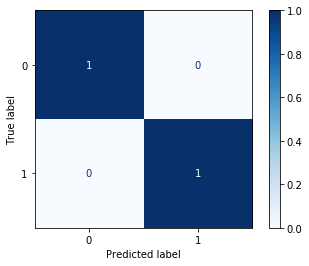

In [53]:
evaluate_model(y_train,y_hat_train,X_train_tfidf,rf)

              precision    recall  f1-score   support

           0       0.79      0.69      0.74        72
           1       0.81      0.88      0.85       109

    accuracy                           0.81       181
   macro avg       0.80      0.79      0.79       181
weighted avg       0.81      0.81      0.80       181



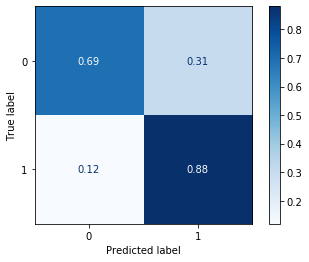

In [54]:
evaluate_model(y_test,y_hat_test,X_test_tfidf,rf)

In [55]:
# help(rf.estimators_[0].get_depth)

In [56]:
rf.estimators_[0].get_depth()

89

### Get feature importances as text

In [57]:
X_train_tfidf.shape

(422, 2149)

In [58]:
len(vectorizer.vocabulary_)

2149

In [59]:
vectorizer.get_feature_names()[:10]

['#1in',
 '#ahca',
 '#americafirst',
 '#draintheswam',
 '#dts',
 '#facebook',
 '#fakenews',
 '#family',
 '#familytime',
 '#godblesstheusa']

//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 127480 missing from current font.
  font.load_char(ord(s), flags=flags)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 127482 missing from current font.
  font.load_char(ord(s), flags=flags)


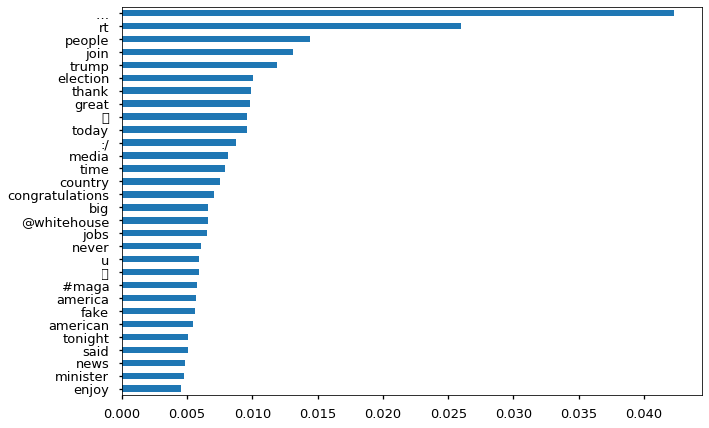

In [60]:
# vectorizer.get_feature_names()
with plt.style.context('seaborn-talk'):
    importance = pd.Series(rf.feature_importances_,index= vectorizer.get_feature_names())
    importance.sort_values().tail(30).plot(kind='barh')

In [61]:
vectorizer.inverse_transform(vectorizer.idf_)

[array(['#1in', '#ahca', '#americafirst', ..., '🇱', '🇸', '🇺'], dtype='<U32')]

In [62]:
help(vectorizer)

Help on TfidfVectorizer in module sklearn.feature_extraction.text object:

class TfidfVectorizer(CountVectorizer)
 |  Convert a collection of raw documents to a matrix of TF-IDF features.
 |  
 |  Equivalent to :class:`CountVectorizer` followed by
 |  :class:`TfidfTransformer`.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : str {'filename', 'file', 'content'}
 |      If 'filename', the sequence passed as an argument to fit is
 |      expected to be a list of filenames that need reading to fetch
 |      the raw content to analyze.
 |  
 |      If 'file', the sequence items must have a 'read' method (file-like
 |      object) that is called to fetch the bytes in memory.
 |  
 |      Otherwise the input is expected to be a sequence of items that
 |      can be of type string or byte.
 |  
 |  encoding : str, default='utf-8'
 |      If bytes or files are given to analyze, this encoding is used to
 |      decode.
 |  
 |

## GridSearch

In [63]:
from sklearn.model_selection import GridSearchCV
params  = {'criterion':['gini','entropy'],
           'max_depth':[5,10,50,100,None],
          'class_weight':['balanced',None],
          'min_samples_leaf':[1,2]}
rf_clf = RandomForestClassifier()
grid = GridSearchCV(rf_clf,params, scoring='recall',n_jobs=-1)
grid.fit(X_train_tfidf,y_train)
grid.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1}

In [64]:
grid.best_score_

1.0

In [65]:
best_rf = grid.best_estimator_
best_rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [66]:
y_hat_test = best_rf.predict(X_test_tfidf)

              precision    recall  f1-score   support

           0       1.00      0.25      0.40        72
           1       0.67      1.00      0.80       109

    accuracy                           0.70       181
   macro avg       0.83      0.62      0.60       181
weighted avg       0.80      0.70      0.64       181



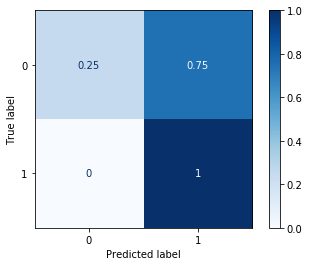

In [67]:
evaluate_model(y_test,y_hat_test,X_test_tfidf,best_rf)

## other clfs

              precision    recall  f1-score   support

           0       0.96      0.62      0.76        72
           1       0.80      0.98      0.88       109

    accuracy                           0.84       181
   macro avg       0.88      0.80      0.82       181
weighted avg       0.86      0.84      0.83       181



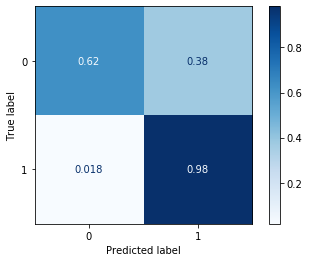

In [69]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf,y_train)
y_hat_test = nb_classifier.predict(X_test_tfidf)
evaluate_model(y_test,y_hat_test,X_test_tfidf,nb_classifier)